In [120]:
%run main.py
%run modeling.py
%run EDAmain.py

# İçindekiler

#### 1- Configurations
#### 2- Data Preparation
###### 2.1- Prepare Train/Test dataset
###### 2.2- Encoding & Scaling
#### 3- Modeling
###### 3.1 Utility Functions
###### 3.2 CatBoost
###### 3.3 XGBoost
###### 3.4 LGBM
###### 3.5 Stacking Ensemble
#### 4- Load Model

In [96]:
df = pd.read_csv("D:\SERKAN KIZILIRMAK\Python\AllProjects\Müşteri Kayıp Analizi (TelcoCustomer)\Data\TelcoCustomer(TR)_binned.csv")

In [97]:
df["Kayıp Durumu"].head()

0    Yok
1    Yok
2    Var
3    Yok
4    Var
Name: Kayıp Durumu, dtype: object

In [98]:
df["Kayıp Durumu"]=[1 if kod=="Var" else 0 for kod in df["Kayıp Durumu"]]

# Configurations

# Data Preparation

### 2.1 Prepare Train/Test dataset

In [99]:
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
for train_index, test_index in strat_split.split(df, df["Kayıp Durumu"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

print('Target Labels Ratio in Original Dataset\n')
print(df["Kayıp Durumu"].value_counts(normalize=True).sort_index())
# df_churn_cleaned["Churn"].value_counts() / len(strat_test_set)

print('\nTarget Labels Ratio in Test Dataset\n')
print(strat_test_set["Kayıp Durumu"].value_counts(normalize=True).sort_index())
# strat_test_set["Churn"].value_counts() / len(strat_test_set)

Target Labels Ratio in Original Dataset

0    0.73463
1    0.26537
Name: Kayıp Durumu, dtype: float64

Target Labels Ratio in Test Dataset

0    0.734564
1    0.265436
Name: Kayıp Durumu, dtype: float64


In [100]:
# train Dataset
X = strat_train_set.drop("Kayıp Durumu", axis=1)
y = strat_train_set["Kayıp Durumu"].copy()

# test dataset
y_test = strat_test_set['Kayıp Durumu'].values
X_test = strat_test_set.drop('Kayıp Durumu',axis=1)

X.shape, y.shape, X_test.shape, y_test.shape

((5634, 22), (5634,), (1409, 22), (1409,))

In [101]:
# Check cardinality of categorical variables :

# reinitiate cat_cols because 'customerID' is still included in cat_cols variable
cat_cols = list(set(X.columns) - set(X._get_numeric_data().columns))
num_cols = list(set(X._get_numeric_data().columns) - set({'65 Yaş Üstü'})) # already converted
# Get number of unique entries in each column with categorical data
object_nunique = list(map(lambda col: X[col].nunique(), cat_cols))
d = dict(zip(cat_cols, object_nunique))

print("Number of unique entries by column, in ascending order:\n")

sorted_cols_by_cardinality = sorted(d.items(), key=lambda x: x[1])
display(pd.DataFrame(sorted_cols_by_cardinality, columns=['Columns', 'Cardinality']))

print("Total Categorical Columns",len(cat_cols))
print("Total Numerical Columns",len(num_cols))

printmd("**<br>Dataset has maximum cardinality value of 4 which is comparatively low<br>**")

Number of unique entries by column, in ascending order:



,Columns,Cardinality
0,Cinsiyet,2
1,Medeni Durum,2
2,Online Fatura(Kağıtsız),2
3,Bakma Sorumluluğu,2
4,Ev Telefonu Aboneliği,2
5,Müşteri Olma Süresi(Ay)-binned,3
6,Teknik Destek Aboneliği,3
7,Birden Fazla Abonelik Durumu,3
8,Güvenlik Hizmeti Aboneliği,3
9,Yedekleme Hizmeti Aboneliği,3


Total Categorical Columns 18
Total Numerical Columns 3


**<br>Dataset has maximum cardinality value of 4 which is comparatively low<br>**

# 2.2 Encoding & Scaling

In [102]:
ordinal_encoder = OrdinalEncoder()
X[cat_cols] = ordinal_encoder.fit_transform(X[cat_cols])
X_test[cat_cols] = ordinal_encoder.transform(X_test[cat_cols])

le = LabelEncoder()
y = le.fit_transform(y)

y_test = le.fit_transform(y_test)


num_cols = ['Müşteri Olma Süresi(Ay)', 'Aylık Ücret', 'Toplam Ücret']

transformer = RobustScaler()
X[num_cols] = transformer.fit_transform(X[num_cols])
X_test[num_cols] = transformer.transform(X_test[num_cols])

Correlation Heatmap
Pearson’s R (parametric) is not applicable when the data is categorical

Kendall’s Tau is a non-parametric measure of relationships between continuous or ordinal features

While Pearson's correlation assesses linear relationships, Spearman's correlation (non -parametric) assesses monotonic relationships (whether linear or not)

Most of the features in this dataset are categorical and nominal, so it's ineffective for those non-numerical attributes

Moreover, there are only three numerical features which are not normally distributed

Therefore, pandas.corr() is not feasible to use for this case

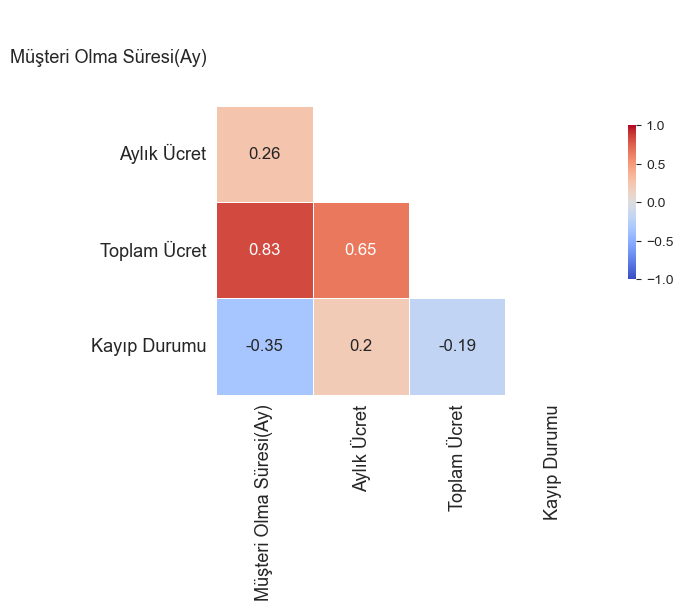

**Tenure is moderately correlated Numerical Feature with Target**

In [103]:
# Correlation Matrix
# only numerical output
corr_matrix = pd.concat([X[num_cols],strat_train_set[["Kayıp Durumu"]]],axis=1).corr() # 'spearman' / 'pearson' / 'kendall'

# Set Up Mask To Hide Upper Triangle
mask = np.zeros_like(corr_matrix, dtype=np.bool_)
mask[np.triu_indices_from(mask)]= True

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(7, 5))
    ax = sns.heatmap(corr_matrix,
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4,
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1,
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': 12})

#add the column names as labels
ax.set_yticklabels(corr_matrix.columns, rotation = 0, fontsize=13)
ax.set_xticklabels(corr_matrix.columns, fontsize=13)

sns.set_style({'xtick.bottom': True}, {'ytick.left': True})
plt.show()

printmd("**Tenure is moderately correlated Numerical Feature with Target**")

# 3- Modeling

3.1.1 Utility Function

In [104]:
def train_model(model, model_name, X, y, X_test, fold):
    printmd(f'**{model_name} Init**')
    auc_scores = []

    test_preds=None

    strat_kf = StratifiedKFold(n_splits=fold, random_state=SEED, shuffle=True)

    for fold, (train_index, valid_index) in enumerate(strat_kf.split(X, y)):
        X_train, X_valid = X.iloc[train_index] , X.iloc[valid_index]
        y_train, y_valid = y[train_index] , y[valid_index]


        #### to SMOTE sampling
        # sm = SMOTE(sampling_strategy='all', random_state=SEED)
        # X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train, y_train)
        # X_val_oversampled, y_val_oversampled = sm.fit_resample(X_valid, y_valid)

        eval_set = [(X_valid, y_valid)]

        print("-" * 50)
        print(f"Fold {fold + 1}")

        if model_name == 'cat':
            model.fit(X_train, y_train, eval_set= eval_set, verbose=False)
        elif model_name == 'xgb':
            model.fit(X_train, y_train, eval_set= eval_set, eval_metric = 'auc', verbose = False, early_stopping_rounds = 200)
        else:
            model.fit(X_train, y_train, eval_set= eval_set, eval_metric = 'auc', verbose = False, early_stopping_rounds = 200)


        val_pred = model.predict_proba(X_valid)[:,1]
        auc = roc_auc_score(y_valid, val_pred) # AUROC requires probabilities of the predictions
        print("AUC Score : ",auc)

        auc_scores.append(auc)

        if test_preds is None:
            test_preds = model.predict_proba(X_test)[:,1]
        else:
            test_preds += model.predict_proba(X_test)[:,1]


        del X_train, y_train, X_valid, y_valid
        gc.collect()

    print("-" * 50)
    test_preds /= fold

    print(f'Train : Base Model - {model_name} - AUC score : mean ---> {np.mean(auc_scores)}, std ---> {np.std(auc_scores)}')

    # evaluation on test set
    print(f'Test  : Base Model - {model_name} - AUC score : {roc_auc_score(y_test, test_preds)}')

    del test_preds
    gc.collect()

    print('Done!')

    if model_name == 'cat':
        plot_feature_importance(model.get_feature_importance(), X.columns, model_name)
        model.save_model("model_catboost")

    elif model_name == 'xgb':
        plot_feature_importance(model.feature_importances_, X.columns, model_name)

        # https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html
        # save the model
        model.save_model('model_xgb.json')

    else:
        plot_feature_importance(model.feature_importances_, X.columns, model_name)
        model.booster_.save_model('model_lgbm.txt')
        joblib.dump(model, 'model_lgbm.pkl')

3.1.2. Model Interpretation

In [105]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8),dpi=100)
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

# credit : https://www.analyseup.com/learn-python-for-data-science/python-random-forest-feature-importance-plot.html

# 3.2 Catboost

In [106]:
#### 3.2.1 Training

**cat Init**

--------------------------------------------------
Fold 1
AUC Score :  0.8266505636070854
--------------------------------------------------
Fold 2
AUC Score :  0.8639210950080514
--------------------------------------------------
Fold 3
AUC Score :  0.8377536231884058
--------------------------------------------------
Fold 4
AUC Score :  0.8321014492753624
--------------------------------------------------
Fold 5
AUC Score :  0.842217034659404
--------------------------------------------------
Fold 6
AUC Score :  0.8562315598352949
--------------------------------------------------
Fold 7
AUC Score :  0.8686817105988394
--------------------------------------------------
Fold 8
AUC Score :  0.8616622896605388
--------------------------------------------------
Fold 9
AUC Score :  0.8550319359335992
--------------------------------------------------
Fold 10
AUC Score :  0.8711702986279257
--------------------------------------------------
Train : Base Model - cat - AUC score : mean ---> 

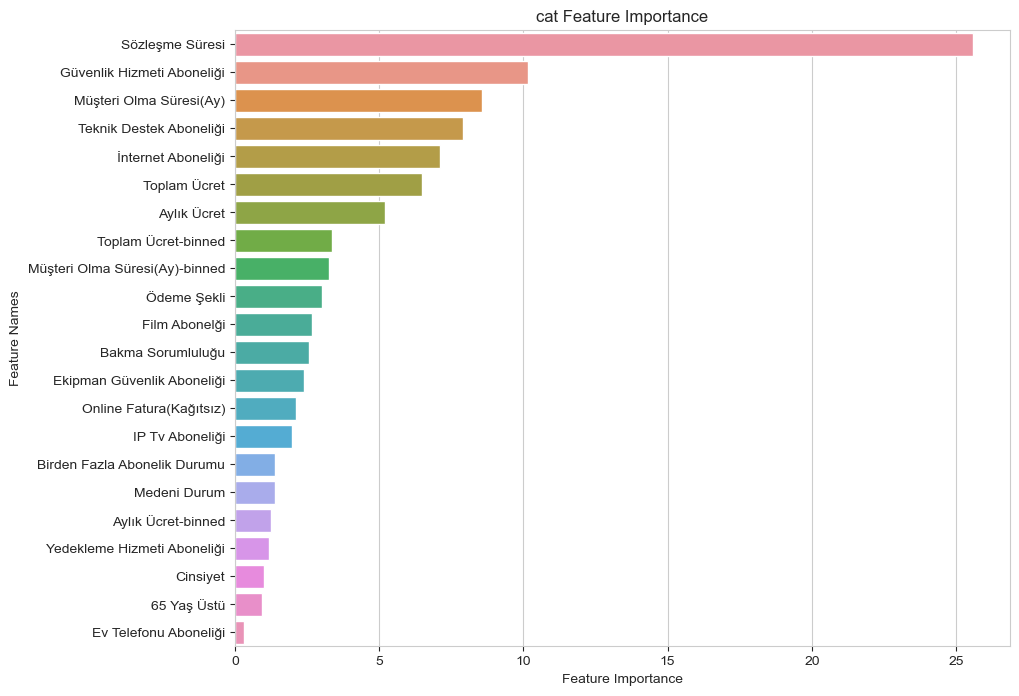

In [111]:
%%time
# https://catboost.ai/en/docs/concepts/speed-up-training

# this dataset is fairly small, so catboost runs super slow on GPU
# https://github.com/catboost/catboost/issues/1034


fold_num = 10

# convert datatype to integer -> use 'cat_features' parameter
# it does not improve score, feel free to try it out
# for c in cat_cols:
#     X[c] = X[c].astype(np.int)
#     X_test[c] = X_test[c].astype(np.int)

cat_params  = {
    'eval_metric':"AUC",
    'loss_function': 'logloss',
    'objective': 'Logloss',
    'boosting_type': 'Plain',
    'bootstrap_type': 'Bayesian',
    'colsample_bylevel': 0.013457968759952536, # does not support on gpu https://catboost.ai/en/docs/references/training-parameters/common#rsm
    'depth': 6,
    'iterations': 6888,
    'learning_rate': 0.05683590866750785,
    'random_strength': 18,
    'l2_leaf_reg': 50,
    'random_state': SEED,
#     'task_type':"GPU",
#     'devices' : '0',
    # 'cat_features':cat_cols
    }


cat = CatBoostClassifier(**cat_params)

train_model(cat, 'cat', X, y, X_test, fold_num)

# 3.2.2 Optuna Tunning

In [122]:
%%time
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=int(SEED), shuffle=True, stratify=y)

    # parameters
    params = {
        'iterations' : trial.suggest_int('iterations', 6000, 8000),
        'depth' : trial.suggest_int('depth', 3, 12),
        'learning_rate' :trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
        "objective": trial.suggest_categorical("objective", ["Logloss"]),
        'colsample_bylevel': trial.suggest_float("colsample_bylevel", 0.01, 0.1), #  # does not support on gpu
        'random_strength' :trial.suggest_int('random_strength', 0, 100),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
        "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]  # https://catboost.ai/en/docs/concepts/algorithm-main-stages_bootstrap-options
        ),
        'random_state': trial.suggest_categorical('random_state',[SEED]),
    }

    # learning
    model = CatBoostClassifier(
        loss_function="Logloss",
        eval_metric="AUC",
        # task_type="GPU",
        l2_leaf_reg=50,
#         border_count=64,
        **params
    )
    model.fit(X_train, y_train,
              verbose=False) # 1000
    val_preds = model.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, val_preds) # AUROC requires probabilities of the predictions
    # print("AUC Score : ",auc) # check the auc score in each trial

    return auc

Wall time: 0 ns


In [123]:
%%time
n_trials = int(150)

# set logging level
# optuna.logging.set_verbosity(optuna_verbosity)

study = optuna.create_study(direction = "maximize", sampler = optuna.samplers.TPESampler(seed=int(SEED)))
study.optimize(objective, n_trials = n_trials, n_jobs = multiprocessing.cpu_count())

printmd('**BEST TRIAL**')
print("Best Score: ", study.best_value)
printmd('**CatBoost Tuned Hyperparameters**')
pprint.pprint(study.best_trial.params)

[I 2023-02-05 16:40:54,288] A new study created in memory with name: no-name-58b5573b-6662-4f67-aa3a-242046c75929
[I 2023-02-05 16:41:15,408] Trial 1 finished with value: 0.8257795344751866 and parameters: {'iterations': 6848, 'depth': 10, 'learning_rate': 0.03602708852995868, 'objective': 'Logloss', 'colsample_bylevel': 0.044899098737138196, 'random_strength': 70, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'random_state': 42}. Best is trial 1 with value: 0.8257795344751866.
[I 2023-02-05 16:41:15,683] Trial 0 finished with value: 0.8326254876126998 and parameters: {'iterations': 7241, 'depth': 3, 'learning_rate': 0.06842666628416849, 'objective': 'Logloss', 'colsample_bylevel': 0.03141530957358269, 'random_strength': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'random_state': 42}. Best is trial 0 with value: 0.8326254876126998.
[I 2023-02-05 16:41:16,915] Trial 5 finished with value: 0.8347399829497015 and parameters: {'iterations': 7474, 'depth': 11, 'learning_

**BEST TRIAL**

Best Score:  0.8414774341884316


**CatBoost Tuned Hyperparameters**

{'boosting_type': 'Plain',
 'bootstrap_type': 'Bernoulli',
 'colsample_bylevel': 0.015788765694226832,
 'depth': 4,
 'iterations': 6437,
 'learning_rate': 0.018936364280258397,
 'objective': 'Logloss',
 'random_state': 42,
 'random_strength': 78}
Wall time: 19min 30s


In [124]:
# Save
pickle.dump(study.best_trial.params, open('CatBoost_Hyperparameter.pickle', 'wb'))
print("Best Score: ", study.best_value)

printmd('**CatBoost Tuned Hyperparameters**')
pprint.pprint(study.best_trial.params)

# history
display(optuna.visualization.plot_optimization_history(study))

# Importance
display(plot_param_importances(study))

Best Score:  0.8414774341884316


**CatBoost Tuned Hyperparameters**

{'boosting_type': 'Plain',
 'bootstrap_type': 'Bernoulli',
 'colsample_bylevel': 0.015788765694226832,
 'depth': 4,
 'iterations': 6437,
 'learning_rate': 0.018936364280258397,
 'objective': 'Logloss',
 'random_state': 42,
 'random_strength': 78}
